In [266]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

In [ ]:
#Prints Results of Regression Metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Function Source: [Stack Overflow](https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does)

In [216]:
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [217]:
#Drop Missing Values
data = data.dropna()

In [218]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [219]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64

Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64

Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64

Distance_from_Home
Near        3801
Moderate    1941
Fa

In [220]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"]

,Exam_Score
Hours_Studied,0.445104
Attendance,0.580259
Sleep_Hours,-0.017171
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148
Exam_Score,1.000000


<Axes: xlabel='Attendance', ylabel='Exam_Score'>

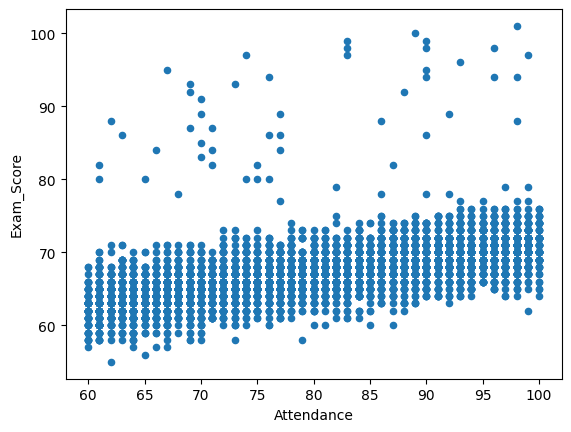

In [221]:
#scatter plot attendance verse exam score
data.plot.scatter(x='Attendance', y='Exam_Score')

In [222]:
#fit a one hot encoder to the categorical data
ohe = OneHotEncoder(drop='first')
categoricals_trans = ohe.fit_transform(categoricals)

In [223]:
#create a matrix from the transformed categorical data
categoricals_trans.todense()

matrix([[1., 0., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 1., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 1., 1.]])

In [224]:
#turn the matrix into a dataframe
categoricals_ohe = pd.DataFrame(categoricals_trans.todense(), columns=ohe.get_feature_names_out())

In [225]:
#combine the reformated categorical columns with the numerical columns
data = pd.concat([numericals, categoricals_ohe], axis=1)

In [226]:
data = data.dropna()

In [227]:
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
#Create a single linear regression model using only the most correlated variable as a baseline
single_linear_regression = sm.OLS(endog=y_train, exog=sm.add_constant(X_train[['Attendance']]))
single_linear_regression_results = single_linear_regression.fit()
print(single_linear_regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     2470.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:11:09   Log-Likelihood:                -12714.
No. Observations:                4929   AIC:                         2.543e+04
Df Residuals:                    4927   BIC:                         2.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6834      0.317    163.070      0.0

In [236]:
slr = LinearRegression()
slr.fit(X_train[['Attendance']], y_train)
y_pred = slr.predict(X_test[['Attendance']])
regression_results(y_test, y_pred)

explained_variance:  0.3561
mean_squared_log_error:  0.0019
r2:  0.3556
MAE:  2.0966
MSE:  9.5561
RMSE:  3.0913


In [241]:
slr_cv = cross_val_score(slr, X_train[['Attendance']], y_train, scoring = 'neg_root_mean_squared_error', cv=5)

slr_cv_rmse = -(slr_cv.mean())
print(slr_cv_rmse)

3.185161747456511


In [233]:
multiple_lin_reg = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))
multiple_lin_reg_results = multiple_lin_reg.fit()
multiple_lin_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     262.2
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:11:38   Log-Likelihood:                -11513.
No. Observations:                4929   AIC:                         2.308e+04
Df Residuals:                    4901   BIC:                         2.326e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    41.2607      0.472     87.367      0.000      40.335      42.187
Hours_Studied                             0.2911      0.006     48.485      0.000       0.279       0.303
Attendance                                0.1973      0.003     63.925      0.000       0.191       0.203
Sleep_Hours                              -0.0117      0.024     -0.481      0.630      -0.060       0.036
Previous_Scores                           0.0474      0.002     19.015      0.000       0.043       0.052
Tutoring_Sessions                         0.4995      0.029     17.271      0.000       0.443       0.556
Physical_Activity                         0.1338      0.035      3.840      0.000       0.065       0.202
Parental_Involvement_Low                  0.2521      0.104      2.421      0.016       0.048       0.456
Parental_Involvement_Medium               0.0151      0.083      0.181      0.856      -0.148       0.178
Access_to_Resources_Low                   0.0177      0.103      0.171      0.864      -0.185       0.220
Access_to_Resources_Medium               -0.0154      0.083     -0.185      0.853      -0.178       0.147
Extracurricular_Activities_Yes            0.0778      0.073      1.066      0.286      -0.065       0.221
Motivation_Level_Low                     -0.0566      0.104     -0.546      0.585      -0.260       0.147
Motivation_Level_Medium                  -0.1092      0.095     -1.152      0.249      -0.295       0.077
Internet_Access_Yes                      -0.0040      0.134     -0.030      0.976      -0.267       0.259
Family_Income_Low                        -0.0456      0.099     -0.460      0.646      -0.240       0.149
Family_Income_Medium                     -0.1237      0.099     -1.244      0.214      -0.319       0.071
Teacher_Quality_Low                      -0.1340      0.131     -1.021      0.307      -0.391       0.123
Teacher_Quality_Medium                   -0.2216      0.080     -2.775      0.006      -0.378      -0.065
School_Type_Public                       -0.0910      0.078     -1.163      0.245      -0.244       0.062
Peer_Influence_Neutral                    0.1454      0.097      1.505      0.132      -0.044       0.335
Peer_Influence_Positive                   0.1411      0.096      1.464      0.143      -0.048       0.330
Learning_Disabilities_Yes                -0.0466      0.117     -0.399      0.690      -0.275       0.182
Parental_Education_Level_High School      0.0347      0.083      0.420      0.675      -0.128       0.197
Parental_Education_Level_Postgraduate    -0.0200      0.103     -0.194      0.846      -0.222       0.182
Distance_from_Home_Moderate              -0.1337      0.131     -1.019      0.308      -0.391       0.123
Distance_

In [237]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.6348
mean_squared_log_error:  0.001
r2:  0.6348
MAE:  1.3098
MSE:  5.4154
RMSE:  2.3271


In [242]:
mlr_cv = cross_val_score(mlr, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=5)

mlr_cv_rmse = -(mlr_cv.mean())
print(mlr_cv_rmse)

2.509040146660668


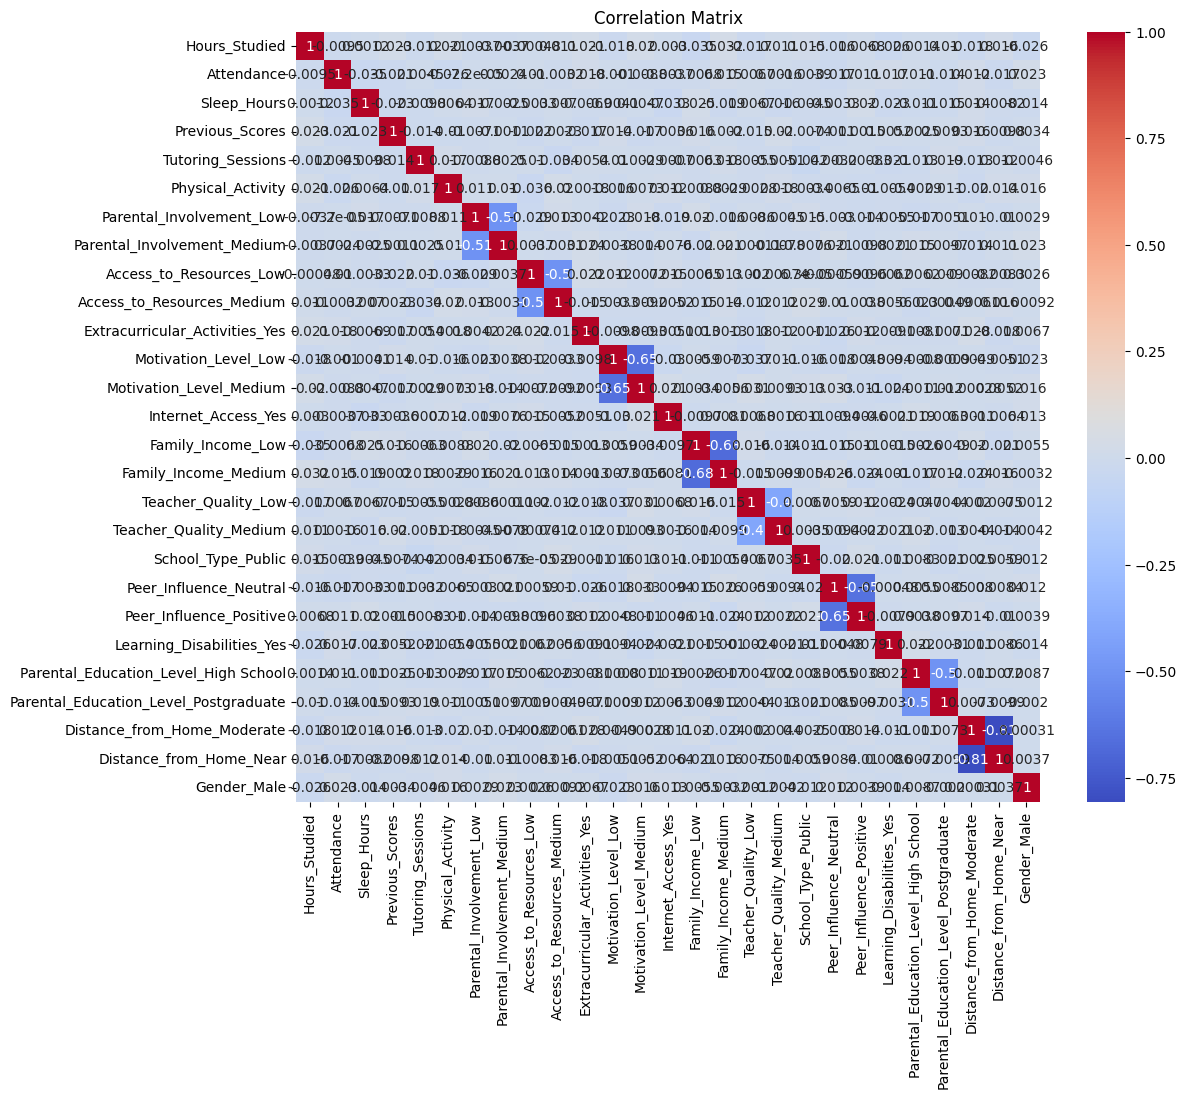

In [234]:
# Correlation matrix
correlation_matrix = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [250]:
X_train_sig = X_train.drop(columns=['Sleep_Hours', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes', 'Motivation_Level_Low', 'Motivation_Level_Medium',
                           'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low', 'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes',
                           'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Male', 'Parental_Education_Level_High School'], axis=1)

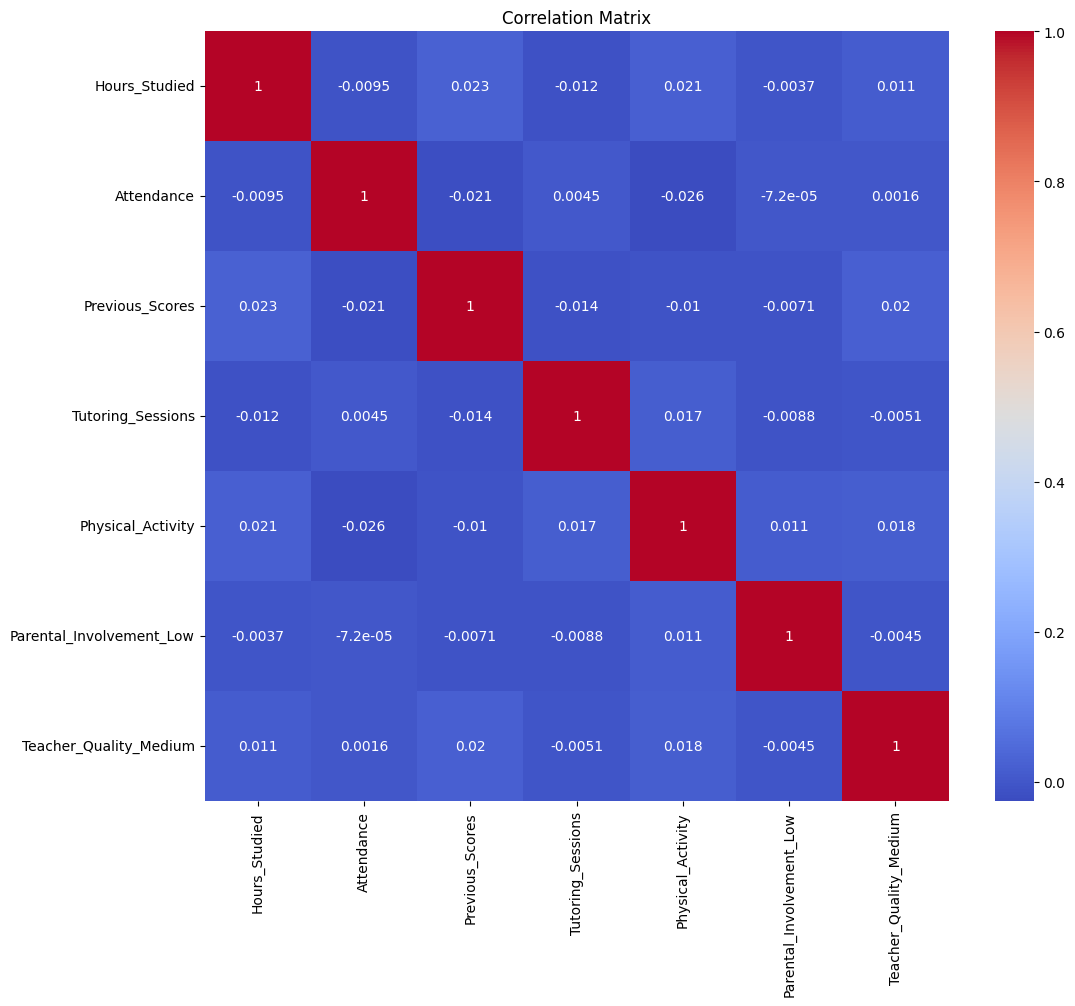

In [251]:
correlation_matrix_sig = X_train_sig.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_sig, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [252]:
multiple_linear_regression_significant_variables = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_sig))
multiple_linear_regression_significant_variables_results = multiple_linear_regression_significant_variables.fit()
multiple_linear_regression_significant_variables_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     1011.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:51:54   Log-Likelihood:                -11519.
No. Observations:                4929   AIC:                         2.305e+04
Df Residuals:                    4921   BIC:                         2.311e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       41.0008      0.358    114.480      0.000      40.299      41.703
Hours_Studied                0.2908      0.006     48.589      0.000       0.279       0.303
Attendance                   0.1974      0.003     64.139      0.000       0.191       0.203
Previous_Scores              0.0474      0.002     19.042      0.000       0.043       0.052
Tutoring_Sessions            0.5005      0.029     17.361      0.000       0.444       0.557
Physical_Activity            0.1327      0.035      3.819      0.000       0.065       0.201
Parental_Involvement_Low     0.2366      0.089      2.648      0.008       0.061       0.412
Teacher_Quality_Medium      -0.1885      0.073     -2.586      0.010      -0.331      -0.046
==============================================================================
Omnibus:                     5999.481   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           875698.343
Skew:                           6.510   Prob(JB):                         0.00
Kurtosis:                      66.987   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [253]:
mlr_sig = LinearRegression()
mlr_sig.fit(X_train_sig, y_train)
y_pred = mlr_sig.predict(X_test[X_train_sig.columns])
regression_results(y_test, y_pred)

explained_variance:  0.6357
mean_squared_log_error:  0.001
r2:  0.6357
MAE:  1.3085
MSE:  5.4027
RMSE:  2.3244


In [255]:
mlr_sig_cv = cross_val_score(mlr_sig, X_train_sig, y_train, scoring = 'neg_root_mean_squared_error', cv=5)

mlr_sig_cv_rmse = -(mlr_sig_cv.mean())
print(mlr_sig_cv_rmse)

2.498690920293392


In [268]:
parameters = {'poly__degree': range(1, 11),
              'poly__interaction_only': [True, False],
              'poly__include_bias': [True, False],
              'poly__order': ['C', 'F']} '

mlr_sig_poly = LinearRegression()

# Create a pipeline to include PolynomialFeatures transformation
poly = PolynomialFeatures()

# Create pipeline with PolynomialFeatures and LinearRegression
pipeline = Pipeline([('poly', poly), ('linear', mlr_sig_poly)])

clf = GridSearchCV(estimator=pipeline,
                   param_grid=parameters,
                   scoring='neg_root_mean_squared_error',
                   cv=5)

# Fit the pipeline
clf.fit(X_train_sig, y_train)

# Access the best degree found by GridSearchCV
best_degree = clf.best_params_['poly__degree']

# Create a new PolynomialFeatures object with the best degree
poly_best = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_best.fit_transform(X_train_sig)

# Fit the final model with the best degree
final_model = LinearRegression()
final_model.fit(X_train_poly, y_train)

LinearRegression()

In [269]:
y_pred = final_model.predict(poly_best.transform(X_test[X_train_sig.columns]))
regression_results(y_test, y_pred)

explained_variance:  0.6357
mean_squared_log_error:  0.001
r2:  0.6357
MAE:  1.3085
MSE:  5.4027
RMSE:  2.3244


In [272]:
final_model_cv = cross_val_score(final_model, X_train_poly, y_train, scoring = 'neg_root_mean_squared_error', cv=5)

final_model_cv_rmse = -(final_model_cv.mean())
final_model_cv_rmse

2.4986909202933916

In [260]:
GridSearchCV(estimator=PolynomialFeatures(), param_grid={'degree': range(0, 11), 'interaction_only': [True, False], 'include_bias': [True, False], 'order': ['C', 'F']})

GridSearchCV(estimator=PolynomialFeatures(),
             param_grid={'degree': range(0, 11), 'include_bias': [True, False],
                         'interaction_only': [True, False],
                         'order': ['C', 'F']})